<a href="https://colab.research.google.com/github/jamesgolden1/llms-are-llms/blob/main/notebooks/gemma_3/detached_jacobian_gemma_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Llama 3.2 3B IT with the detached Jacobian is locally linear
This notebook demonstrates how to compute the Jacobian in PyTorch (other demos apply this code within the JacobianAnalyzer class).

In [1]:
%%capture
!pip install "huggingface_hub[hf_transfer]"

In [2]:
import os
from google.colab import userdata

os.environ["HF_HUB_ENABLE_HF_TRANSFER"]='1'
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
!git clone https://github.com/jamesgolden1/llms-are-llms.git

fatal: destination path 'llms-are-llms' already exists and is not an empty directory.


In [4]:
cd llms-are-llms

/content/llms-are-llms


In [5]:
#@title Copy modeling_llama_locally_linear.py into transformers
import shutil
import transformers
transformers_file = transformers.__file__.split('__')[0]

# Llama 3.1
modeling_file_new = "models/gemma_3/modeling_gemma_locally_linear.py"
modeling_file = transformers_file+"models/gemma3/modeling_gemma3.py"
backup_file = transformers_file+"models/gemma3/modeling_gemma_original.py"
shutil.copy(modeling_file, backup_file)
shutil.copy(modeling_file_new, modeling_file)

'/usr/local/lib/python3.11/dist-packages/transformers/models/gemma3/modeling_gemma3.py'

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers.models.gemma.modeling_gemma import *
from transformers import AutoTokenizer, AutoModelForCausalLM

In [7]:
#@title Model
model_id = "google/gemma-3-4b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    # torch_dtype=torch.float32,
    device_map="auto",
).cuda()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
model_mm = model
model = model.language_model

In [17]:
# # Load model directly
# from transformers import AutoProcessor, AutoModelForImageTextToText

# processor = AutoProcessor.from_pretrained("google/gemma-3-4b-it")
# model = AutoModelForImageTextToText.from_pretrained("google/gemma-3-12b-it")

In [41]:
#@title Get input embedding vectors with gradient and generate output: train context
text = "The bridge out of Marin is the"

tokenizer.pad_token = tokenizer.eos_token
inputs = tokenizer([text],padding=True, return_tensors="pt")

inputs = {k: v.to('cuda') for k, v in inputs.items() if k != 'token_type_ids'}

model.train()
outputs_train = model_mm.generate(
                          **inputs,
                          max_new_tokens=1,
                          return_dict_in_generate=True,
                          output_scores=True,
                          past_key_values=None,
                          use_cache=False,
                          output_hidden_states=True,
                          temperature=.001)
print("[", [tokenizer.decode(outputs['sequences'][ii]) for ii in range(len(outputs['sequences']))], "]")

embeds = model.model.embed_tokens(tokenizer.encode(text, return_tensors='pt').cuda())

The following generation flags are not valid and may be ignored: ['cache_implementation']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[ ['<bos>The bridge out of Marin is the Golden'] ]


In [42]:
#@title Get input embedding vectors with gradient and generate output: eval context
text = "The bridge out of Marin is the"

tokenizer.pad_token = tokenizer.eos_token
inputs = tokenizer([text],padding=True, return_tensors="pt")

inputs = {k: v.to('cuda') for k, v in inputs.items() if k != 'token_type_ids'}

model.eval()
outputs = model_mm.generate(
                          **inputs,
                          max_new_tokens=1,
                          return_dict_in_generate=True,
                          output_scores=True,
                          past_key_values=None,
                          use_cache=False,
                          output_hidden_states=True,
                          temperature=.001)
print("[", [tokenizer.decode(outputs['sequences'][ii]) for ii in range(len(outputs['sequences']))], "]")

embeds = model.model.embed_tokens(tokenizer.encode(text, return_tensors='pt').cuda())

The following generation flags are not valid and may be ignored: ['cache_implementation']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[ ['<bos>The bridge out of Marin is the Golden'] ]


In [18]:
#@title Function to predict output embedding for Jacobian comptuation
# import torch
def model_forward(embeds, lstart=0, lsplit=None, key='layer', transform_to_output=False):
    """
    Forward pass through Gemma model layers

    Args:
        embeds: Input embeddings
        lsplit (int): Number of layers to process

    Returns:
        Hidden states after processing
    """

    outdict = {}

    if lsplit is None:
        lsplit = len(model.model.layers)

    # Get batch size and sequence length
    batch_size, seq_length = embeds.shape[:2]

    # Create position IDs
    position_ids = torch.arange(seq_length, device=embeds.device).unsqueeze(0).expand(batch_size, -1)

    # Generate position embeddings for both global and local attention
    position_embeddings_global = model.model.rotary_emb(embeds, position_ids)
    position_embeddings_local = model.model.rotary_emb_local(embeds, position_ids)

    # Create cache position for tracking position in sequence
    cache_position = torch.arange(seq_length, device=embeds.device)

    # Process through layers
    hidden_states = embeds
    for li in range(lstart, lsplit):

        if key == 'layer_input':
            outdict['layer_input']=hidden_states
        elif key == 'attn_input':
            outdict['attn_input']=hidden_states

        # Store residual for skip connection
        residual = hidden_states

        # Apply input layer norm
        hidden_states = model.model.layers[li].input_layernorm(hidden_states)

        # Determine which position embeddings to use based on layer type
        if model.model.layers[li].self_attn.is_sliding:
            position_embeddings = position_embeddings_local
        else:
            position_embeddings = position_embeddings_global

        attention_mask = torch.ones(batch_size, seq_length, dtype=torch.float, device=embeds.device)
        causal_mask = model.model._update_causal_mask(
            attention_mask,
            embeds,
            position_ids.squeeze(0),
            None,  # past_key_values
            False  # output_attentions
        )

        # Apply attention
        hidden_states, self_attn_weights = model.model.layers[li].self_attn(
            hidden_states=hidden_states,
            position_embeddings=position_embeddings,
            attention_mask=causal_mask,
            cache_position=cache_position
        )

        # Save attention output if requested
        if key == 'attn':
            if li == lsplit - 1:
                attn_output = model.model.norm(hidden_states)
                outdict['attn'] = attn_output

        # Apply post attention layer norm
        hidden_states = model.model.layers[li].post_attention_layernorm(hidden_states)

        # Add residual connection
        hidden_states = residual + hidden_states

        # Save attention output if requested
        if key == 'attn_plus_residual':
            if li == lsplit - 1:
                attn_out = model.model.norm(hidden_states)
                outdict['attn_plus_residual'] = attn_out

        # Store residual for MLP block
        residual = hidden_states

        # Apply pre-feedforward layer norm
        hidden_states = model.model.layers[li].pre_feedforward_layernorm(hidden_states)

        if key == 'mlp_input':
            outdict['mlp_input']=hidden_states

        # Apply MLP
        hidden_states = model.model.layers[li].mlp(hidden_states)

        # Save MLP output if requested
        if key == 'mlp':
            if li == lsplit - 1:
                mlp_output = model.model.norm(hidden_states)
                outdict['mlp'] = mlp_output

        # Apply post-feedforward layer norm
        hidden_states = model.model.layers[li].post_feedforward_layernorm(hidden_states)

        # Add residual connection
        hidden_states = residual + hidden_states

    # Apply final normalization if we processed all layers
    if key != "layer_input" and li == lsplit - 1 and not transform_to_output:
        hidden_states = model.model.norm(hidden_states)
    # # Apply final normalization
    # if li == len(self.model.model.layers) - 1:
    #     hidden_states = self.model.model.norm(hidden_states)

    # Store final layer output
    outdict['layer'] = hidden_states

    # Return the last token embedding of the first batch for the requested key
    if key == "layer_input" or  key == "attn_input" or  key == "mlp_input":
        return outdict[key]
    else:
        return outdict[key][0, -1]

In [44]:
#@title Verify forward function is the same as generate for train()
model.train();
torch.mean(torch.abs(outputs_train['hidden_states'][-1][-1][-1][-1]-model_forward(embeds)))

tensor(0., device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)

In [45]:
#@title Verify forward function is the same as generate for eval()
model.eval();
torch.mean(torch.abs(outputs['hidden_states'][-1][-1][-1][-1]-model_forward(embeds)))

tensor(0., device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)

In [21]:
#@title Compute Jacobian
%%time
model.eval();

# Get Jacobian matrices (one matrix for each input embedding vector)
jacobian = torch.autograd.functional.jacobian(model_forward, embeds, vectorize=True,strategy="reverse-mode").squeeze()

# Sum(Jacobian_i*input_embedding_i) equals output
jacobian_by_token = torch.stack([torch.matmul(jacobian[:,ii,:],embeds[0,ii,:].squeeze())[:] for ii in range(jacobian.shape[1])])
jacobian_output = torch.sum(jacobian_by_token,dim=0)#.shape

CPU times: user 4.35 s, sys: 3.91 s, total: 8.26 s
Wall time: 9.9 s


In [22]:
#@title Compare Jacobian reconstruction with output
linear_jacobian_output = jacobian_output
linear_jacobian_output_error = jacobian_output - outputs.hidden_states[-1][-1][0,-1]
outnplinear = linear_jacobian_output_error.cpu().detach().float().numpy()
xvalslin = outputs.hidden_states[-1][-1][-1][-1].cpu().detach().float().numpy()

For lowest Jacobian error, run at float32 precision on an A100. You can also run float32 on CPU on an L4 but it is slow.


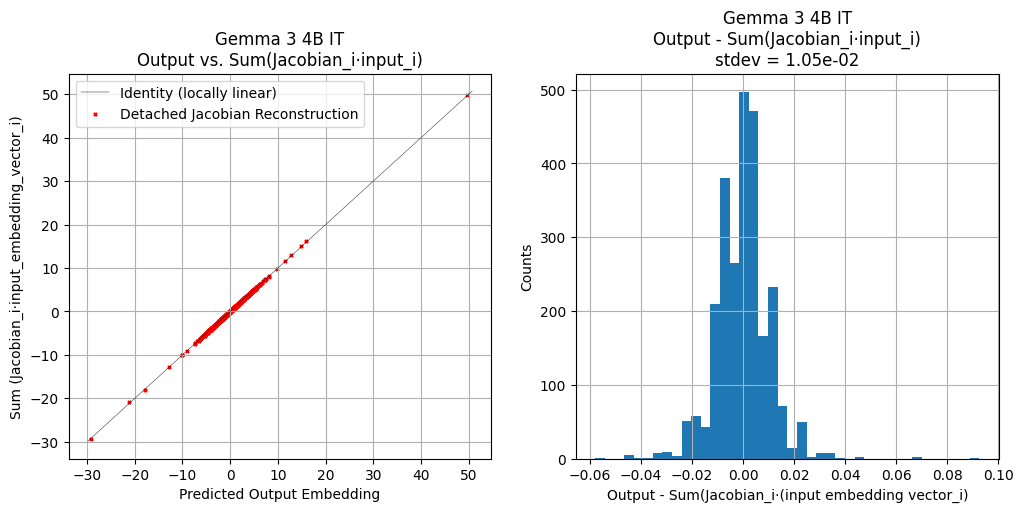

In [23]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
axs = axs.flat
print("For lowest Jacobian error, run at float32 precision on an A100. You can also run float32 on CPU on an L4 but it is slow.")
for n, ax in enumerate(axs):

    if n == 0:

        ax.plot([1.02*np.min(xvalslin), 1.02*np.max(xvalslin)], [1.02*np.min(xvalslin), 1.02*np.max(xvalslin)], 'k', linewidth=0.3)
        ax.scatter(xvalslin,(jacobian_output).cpu().detach().float().numpy(),5,'r',marker='x');

        ax.set_xlabel('Predicted Output Embedding')
        ax.set_ylabel('Sum (Jacobian_i·input_embedding_vector_i)')
        ax.legend(['Identity (locally linear)', 'Detached Jacobian Reconstruction'])
        ax.set_title('Gemma 3 4B IT\nOutput vs. Sum(Jacobian_i·input_i)')
        ax.grid()
    if n == 1:
        outnp = linear_jacobian_output_error.cpu().detach().float().numpy()
        ax.hist(outnp/np.std(outputs.hidden_states[-1][-1][-1][-1].cpu().detach().float().numpy()),bins=40)#,range=[-20,20])#,range=[-7.5e-6,7.5e-6]);
        ax.set_ylabel('Counts')
        ax.set_xlabel('Output - Sum(Jacobian_i·(input embedding vector_i)')
        ax.grid()
        ax.set_title('Gemma 3 4B IT\nOutput - Sum(Jacobian_i·input_i)\nstdev = '+"{val:1.2e}".format(val=np.std(outnp)/np.std(outputs.hidden_states[-1][-1][-1][-1].cpu().detach().float().numpy())))